## Compute Tau values for MAGE data and call either population or continent-specific transcripts. Overlap w/ our pop-specific transcritps.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
def compute_tau(df):
    """
    Compute tissue-specificity index for an abundance matrix output
    from `get_tpm_table`.
    """
    # number of samples 
    n = len(df.columns)
    print(f'Found {n} samples')
    
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # get max of TPM for transcript across samples
    temp = df.max(axis=1)
    temp_ind = temp.index.tolist()

    df = df.transpose()
    df_ind = df.columns.tolist()
    assert df_ind==temp_ind

    # compute x-hat (TPM / max TPM across tissues)
    x_hat = df/temp
    
    # compute (1-x-hat) 
    x_hat = 1-x_hat

    # compute sum across tissues
    x_hat = x_hat.transpose()
    x_hat['sum'] = x_hat.sum(axis=1)
    
    # compute tau for each transcript
    x_hat['tau'] = x_hat['sum']/n
    tau_df = x_hat[['tau']]
    
    return tau_df

In [4]:
# metadata 
# metadata 
# get sampleId, indId, group, batch, run from metadata tables
meta_file = '../snakemake/mage/filereport_read_run_PRJNA851328_tsv.txt'
meta = pd.read_csv(meta_file, sep='\t')

meta['sampleId'] = meta['indId'] = meta.experiment_alias.str.split('_', expand=True)[0]
meta['batch'] = meta.experiment_alias.str.split('_', expand=True)[1]


meta_file = '../snakemake/mage/sample_metadata_parsed.tsv'
df2 = pd.read_csv(meta_file, sep=' ', header=None)
df2.columns = ['sampleId', 'pop', 'continent', 'sex', 'sth', 'sth2']

meta = meta.merge(df2, how='left',
              on='sampleId')
meta['group'] = 1 # all the same group because we don't want to call sqtls separately for anything
meta[['sampleId', 'indId', 'group', 'batch', 'sex', 'pop', 'continent', 'experiment_alias']].head()

,sampleId,indId,group,batch,sex,pop,continent,experiment_alias
0,NA19704,NA19704,1,batch11,female,ASW,AFR,NA19704_batch11_rep1
1,NA19332,NA19332,1,batch14,female,LWK,AFR,NA19332_batch14_rep1
2,NA19317,NA19317,1,batch15,male,LWK,AFR,NA19317_batch15_rep1
3,NA19312,NA19312,1,batch05,male,LWK,AFR,NA19312_batch05_rep1
4,NA19323,NA19323,1,batch11,female,LWK,AFR,NA19323_batch11_rep1


## Compute Tau in MAGE (population)

In [7]:
# enhanced gencode
df = pd.read_csv('../data/mage/poder_kallisto/matrix.abundance.tsv', sep='\t')
df.rename({'transcript_id':'tid'},axis=1, inplace=True)
df.set_index('tid', inplace=True)

In [8]:
# filter things to keep to compute Tau for
# https://academic.oup.com/bib/article/18/2/205/2562739
# min_cpm = 0.1
min_cpm = 1
min_samples = 1

# set all transcripts w/ expression <1 CPM --> 0
df[df < min_cpm] = 0

# remove all genes that are not expressed in at least one tissue
# the text must be wrong here because how can we filter 
# after log normalization for CPM >=1?
print(len(df.index))
df = df.loc[(df>=min_cpm).sum(axis=1)>=min_samples]
print(len(df.index))

# log-transform data and add 1 pseudocount
df = np.log2(df+1)

155875
155230


In [9]:
# get the median expression value across samples from the same populations
# using the median because we want to remove the effect 
# of individual samples expression patterns on the analysis
df = df.transpose()
df.reset_index(inplace=True)
df.rename({'index':'experiment_alias'}, axis=1, inplace=True)
df = df.merge(meta[['experiment_alias', 'pop']], 
              how='left', on='experiment_alias')
# df = df.groupby('population').median().reset_index()
df = df.groupby('pop').mean().reset_index()
df.set_index('pop', inplace=True)
df.index.name = ''
df = df.transpose()
df.head()

,ACB,ASW,BEB,CDX,CEU,CHB,CHS,CLM,ESN,FIN,...,KHV,LWK,MSL,MXL,PEL,PJL,PUR,STU,TSI,YRI
ENST00000010132.6,4.606798,4.715326,3.942034,4.553029,4.534779,4.833937,4.057397,4.263926,4.746702,4.188297,...,4.011795,4.858107,4.890173,4.697094,4.851644,4.956123,4.213273,4.950100,4.532337,4.751172
ENST00000013894.3,2.138115,2.113123,2.318716,1.957901,1.670014,2.399553,2.345971,2.659435,2.484787,2.359563,...,2.406762,2.528307,2.842165,2.271695,2.545637,2.126250,2.312493,2.625532,2.260684,2.396051
ENST00000075120.12,11.198226,10.886534,11.526728,11.494778,10.500350,11.529458,11.546166,11.512626,11.224656,11.244556,...,11.679175,11.129600,11.110181,11.318014,11.659387,11.288696,11.495247,11.325327,11.075188,10.815553
ENST00000155093.8,4.968452,3.193618,3.631482,3.103534,3.225653,4.338551,4.714133,3.757941,4.245798,5.218466,...,2.918403,4.455855,3.674542,4.084179,3.660468,3.441799,3.630896,3.891191,4.662668,3.716456
ENST00000156084.8,5.894066,5.636659,6.727707,6.198356,5.075342,5.861227,5.991725,6.382440,5.971821,6.458669,...,5.281643,6.147742,5.984298,5.797167,6.683708,6.562064,6.470532,5.996012,5.883356,6.186450


In [10]:
tau_df = compute_tau(df)
tau_df.index.name = 'tid'
tau_df.head()

Found 26 samples


,tau
tid,
ENST00000010132.6,0.080575
ENST00000013894.3,0.176715
ENST00000075120.12,0.037998
ENST00000155093.8,0.253669
ENST00000156084.8,0.101522


In [11]:
tau_df.to_csv(f'250127_{min_cpm}_{min_samples}_mage_population_mean_tau.tsv', sep='\t')

In [12]:
tau_df = pd.read_csv(f'250127_{min_cpm}_{min_samples}_mage_population_mean_tau.tsv', sep='\t')

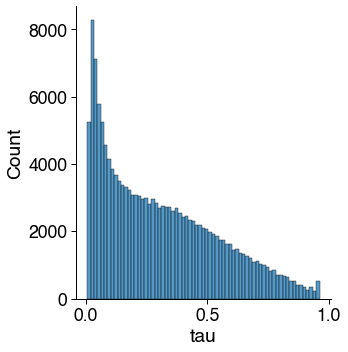

In [13]:
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', kind='hist')

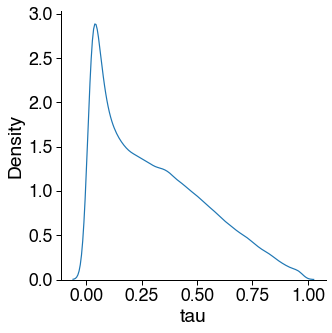

In [14]:
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', kind='kde')

## get population-specific transcripts from PODER

In [15]:
# plot tau value vs. population specific transcripts
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table_fixed_genics.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [16]:
tau_df = tau_df.merge(mt_df[['isoform', 'pop_spec_t']], 
                      how='left', 
                      left_on='tid',
                      right_on='isoform')

In [17]:
tau_df.head()

,tid,tau,isoform,pop_spec_t
0,ENST00000010132.6,0.080575,ENST00000010132.6,False
1,ENST00000013894.3,0.176715,ENST00000013894.3,False
2,ENST00000075120.12,0.037998,ENST00000075120.12,False
3,ENST00000155093.8,0.253669,ENST00000155093.8,False
4,ENST00000156084.8,0.101522,ENST00000156084.8,False


In [18]:
tau_df.loc[tau_df.pop_spec_t.notnull()].head()

,tid,tau,isoform,pop_spec_t
0,ENST00000010132.6,0.080575,ENST00000010132.6,False
1,ENST00000013894.3,0.176715,ENST00000013894.3,False
2,ENST00000075120.12,0.037998,ENST00000075120.12,False
3,ENST00000155093.8,0.253669,ENST00000155093.8,False
4,ENST00000156084.8,0.101522,ENST00000156084.8,False


In [19]:
tau_df['tau_pop_spec_t'] = tau_df.tau>=0.8

In [20]:
tau_df[['tau_pop_spec_t',
        'pop_spec_t', 'tid']].groupby(['pop_spec_t',
                                       'tau_pop_spec_t']).nunique()

tid
pop_spec_t tau_pop_spec_t        
False      False           147863
           True              5108
True       False             2115
           True               144

In [21]:
tau_df['pop_spec_t'] = tau_df['pop_spec_t'].fillna('Absent from PODER') # these are the transcripts that are in GENCODE but not in our anotation

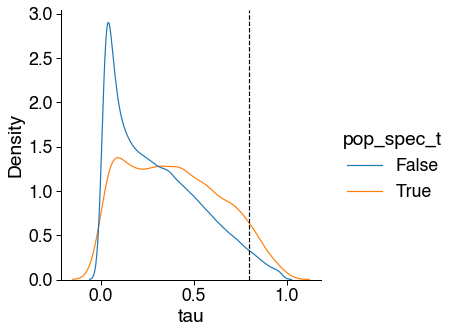

In [22]:
ax = sns.displot(tau_df, x='tau', hue='pop_spec_t', kind='kde',
            common_norm=False)
plt.axvline(0.8, color='k', linestyle='--')

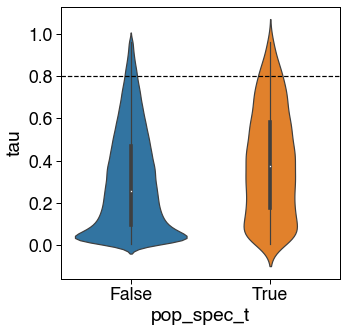

In [23]:
ax = sns.violinplot(tau_df, y='tau', x='pop_spec_t')
plt.axhline(0.8, color='k', linestyle='--')

In [24]:
# first, wilcoxon
 
# hypotheses are that absent transcripts, and pop_spec transcritps have higher tau values than non-pop-spec

for higher_cat in [True]:
    # Split the data based on "pop_spec_t"
    x = tau_df[tau_df['pop_spec_t'] == higher_cat]['tau'] # these should be higher
    y = tau_df[tau_df['pop_spec_t'] == False]['tau'] # these should be lower

    # alt hypothesis is that y > x or x < y

    # ‘two-sided’: one of the distributions (underlying x or y) is stochastically greater than the other.

    # ‘less’:  x < y.

    # ‘greater’:  x > y.

    # do the test
    stat, p_value = st.ranksums(x, y,
                                alternative='greater')


    print(f'Hypoth: {higher_cat} transcripts tau > false pop-spec. disc. transcripts')
    print(f'Wilcoxon Rank Sum Test Statistic: {stat}')
    print(f'P-value: {p_value}')
    print()

Hypoth: Absent from PODER transcripts tau > false pop-spec. disc. transcripts
Wilcoxon Rank Sum Test Statistic: nan
P-value: nan

Hypoth: True transcripts tau > false pop-spec. disc. transcripts
Wilcoxon Rank Sum Test Statistic: 17.259790917491948
P-value: 4.7226153984517965e-67



/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:7784: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


In [26]:
## Fischer's exact test
# hypotheses are that absent transcripts and pop-spec disc. transcripts
# are enriched for pop-spec tau values in mage

for higher_cat in [True]:
    temp = tau_df.loc[tau_df.pop_spec_t.isin([higher_cat, False])]

    temp = temp[['tau_pop_spec_t',
            'pop_spec_t', 'tid']].groupby(['pop_spec_t',
                                           'tau_pop_spec_t']).nunique().reset_index()

    temp.head()
    temp = temp.pivot(index='tau_pop_spec_t',
                      values = 'tid',
                      columns = 'pop_spec_t')
    temp = temp.values
    temp
    # Perform Fisher's Exact Test
    odds_ratio, p_value = st.fisher_exact(temp, alternative='greater')


    # # get the CI of these results
    # result = st.contingency.odds_ratio(temp, kind='conditional')
    # odds_ratio_value = result.statistic
    # confidence_interval = result.confidence_interval(confidence_level=0.95)

    print(f'Hypoth: {higher_cat} transcripts are enriched in pop-spec called by expression')
    print("Odds Ratio:", odds_ratio)
    print("P-value:", p_value)
    print()
    # print("Conditional Odds Ratio:", odds_ratio_value)
    # print("95% Confidence Interval:", confidence_interval)

Hypoth: True transcripts are enriched in pop-spec called by expression
Odds Ratio: 1.970882553857945
P-value: 8.240909327241965e-13

